In [1]:
from google.colab import files
uploaded = files.upload()


Saving media prediction and its cost.csv to media prediction and its cost.csv


In [2]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("media prediction and its cost.csv")
df.head()


,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [8]:
# Đọc file CSV
df = pd.read_csv("media prediction and its cost.csv")
df.dropna(axis=1, how='all', inplace=True)
df.fillna(method='ffill', inplace=True)

# Kiểm tra cột văn bản
print("Các cột dạng văn bản:", df.select_dtypes(include='object').columns)


<ipython-input-8-dfe83a64e818>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Các cột dạng văn bản: Index(['food_category', 'food_department', 'food_family', 'promotion_name',
       'sales_country', 'marital_status', 'gender', 'education', 'member_card',
       'occupation', 'houseowner', 'avg. yearly_income', 'brand_name',
       'store_type', 'store_city', 'store_state', 'media_type'],
      dtype='object')


In [9]:
text_col = 'media_type'
documents = df[text_col].astype(str).values


In [10]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_sparse = vectorizer.fit_transform(documents)

print("Kích thước ma trận TF-IDF:", X_sparse.shape)


Kích thước ma trận TF-IDF: (60428, 15)


In [11]:
y = np.random.randint(0, 2, size=X_sparse.shape[0])  # nhãn giả lập
selector = SelectKBest(score_func=chi2, k=100)
X_selected = selector.fit_transform(X_sparse, y)

selected_features = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
print("Top 10 từ khóa được chọn:", selected_features[:10])


Top 10 từ khóa được chọn: ['attachment' 'bulk' 'cash' 'coupon' 'daily' 'handout' 'mail' 'paper'
 'product' 'radio']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=100 is greater than n_features=15. All the features will be returned.
  warnings.warn(


In [12]:
vt = VarianceThreshold(threshold=0.01)
X_high_variance = vt.fit_transform(X_selected.toarray())
print("Kích thước sau khi lọc phương sai thấp:", X_high_variance.shape)


Kích thước sau khi lọc phương sai thấp: (60428, 15)


In [13]:
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_sparse)

def print_topics(model, feature_names, n_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

print("🔍 Các chủ đề rút ra từ media_type:")
print_topics(lda_model, vectorizer.get_feature_names_out())


🔍 Các chủ đề rút ra từ media_type:
Chủ đề #1: daily, street, handout, paper, radio
Chủ đề #2: tv, register, cash, handout, paper
Chủ đề #3: store, coupon, paper, daily, radio
Chủ đề #4: attachment, product, mail, bulk, paper
Chủ đề #5: radio, paper, sunday, daily, tv


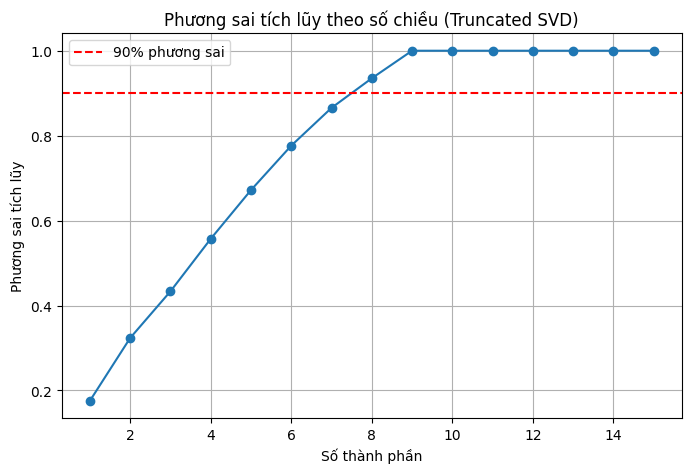

In [16]:
svd = TruncatedSVD(n_components=15, random_state=42)
X_svd = svd.fit_transform(X_sparse)
explained = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
# Thay đổi phạm vi để khớp với số thành phần (15)
plt.plot(range(1, 16), explained, marker='o')
plt.title("Phương sai tích lũy theo số chiều (Truncated SVD)")
plt.xlabel("Số thành phần")
plt.ylabel("Phương sai tích lũy")
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% phương sai')
plt.legend()
plt.show()
